<a href="https://colab.research.google.com/github/ashaaher/Emerging-Technologies/blob/master/Assignment%204/b_Meta_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Meta learning using Omniglot Dataset**

Understanding on Meta learning : 

-Meta learing is a concept of learning to learn fast.

-In meta learning the model is capable of generalizing to new tasks and new environments that have never been encountered during training time.

-This Process of adaptation happens during test but with a limited exposure to the new task configurations. 

-Ultimately the adapted model is able to complete new tasks and this is the reason meta learning is also known as learning to learn.

Downloading the Omniglot Dataset

In [ ]:
!wget https://github.com/ashaaher/Emerging-Technologies/blob/master/Assignment%204/images_background.zip?raw=true

--2020-10-30 23:42:38--  https://github.com/ashaaher/Emerging-Technologies/blob/master/Assignment%204/images_background.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ashaaher/Emerging-Technologies/raw/master/Assignment%204/images_background.zip [following]
--2020-10-30 23:42:39--  https://github.com/ashaaher/Emerging-Technologies/raw/master/Assignment%204/images_background.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ashaaher/Emerging-Technologies/master/Assignment%204/images_background.zip [following]
--2020-10-30 23:42:39--  https://raw.githubusercontent.com/ashaaher/Emerging-Technologies/master/Assignment%204/images_background.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64

In [ ]:
!wget https://github.com/ashaaher/Emerging-Technologies/blob/master/Assignment%204/images_evaluation.zip?raw=true

--2020-10-30 23:42:40--  https://github.com/ashaaher/Emerging-Technologies/blob/master/Assignment%204/images_evaluation.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ashaaher/Emerging-Technologies/raw/master/Assignment%204/images_evaluation.zip [following]
--2020-10-30 23:42:40--  https://github.com/ashaaher/Emerging-Technologies/raw/master/Assignment%204/images_evaluation.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ashaaher/Emerging-Technologies/master/Assignment%204/images_evaluation.zip [following]
--2020-10-30 23:42:40--  https://raw.githubusercontent.com/ashaaher/Emerging-Technologies/master/Assignment%204/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64

In [ ]:
!unzip -q images_background.zip?raw=true
!unzip -q images_evaluation.zip?raw=true

In [ ]:
!ls

 images_background		  'images_evaluation.zip?raw=true'
'images_background.zip?raw=true'   sample_data
 images_evaluation


In [ ]:
!pip3 install 'scipy==1.1.0'

     |████████████████████████████████| 31.2MB 103kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


**Importing required libraries**

In [ ]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

In [ ]:
!mkdir data

In [ ]:
train_folder = "images_background/"
val_folder = 'images_evaluation/'
save_path = 'data/'

In [ ]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [ ]:
X,y,c=loadimgs(train_folder)

loading alphabet: Tagalog
loading alphabet: Arcadian
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Hebrew
loading alphabet: Burmese_(Myanmar)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Latin
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Korean
loading alphabet: Balinese
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: N_Ko
loading alphabet: Armenian
loading alphabet: Grantha
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Tifinagh
loading alphabet: Sanskrit
loading alphabet: Cyrillic
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Futurama
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Greek
loading alphabet: Braille
loading alphabet: Bengali
loading alphabet: Gujarati
loading alphabet: Japanese_(hiragana)
loading alphabet: Early_Aramaic
loading alphabet: Japanese_(katakana)


In [ ]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

In [ ]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Avesta
loading alphabet: Old_Church_Slavonic_(Cyrillic)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Malayalam
loading alphabet: Ge_ez
loading alphabet: Keble
loading alphabet: Mongolian
loading alphabet: Sylheti
loading alphabet: Tibetan
loading alphabet: Glagolitic
loading alphabet: Atemayar_Qelisayer
loading alphabet: Aurek-Besh
loading alphabet: Manipuri
loading alphabet: Oriya
loading alphabet: Syriac_(Serto)
loading alphabet: Atlantean
loading alphabet: Angelic
loading alphabet: Gurmukhi
loading alphabet: Kannada
loading alphabet: Tengwar
loading alphabet: ULOG


In [ ]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [ ]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [ ]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [ ]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [ ]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]      

In [ ]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [ ]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Tagalog', 'Arcadian', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Hebrew', 'Burmese_(Myanmar)', 'Mkhedruli_(Georgian)', 'Syriac_(Estrangelo)', 'Latin', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Balinese', 'Malay_(Jawi_-_Arabic)', 'N_Ko', 'Armenian', 'Grantha', 'Asomtavruli_(Georgian)', 'Alphabet_of_the_Magi', 'Tifinagh', 'Sanskrit', 'Cyrillic', 'Anglo-Saxon_Futhorc', 'Futurama', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Greek', 'Braille', 'Bengali', 'Gujarati', 'Japanese_(hiragana)', 'Early_Aramaic', 'Japanese_(katakana)']


In [ ]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Avesta', 'Old_Church_Slavonic_(Cyrillic)', 'Malayalam', 'Ge_ez', 'Keble', 'Mongolian', 'Sylheti', 'Tibetan', 'Glagolitic', 'Atemayar_Qelisayer', 'Aurek-Besh', 'Manipuri', 'Oriya', 'Syriac_(Serto)', 'Atlantean', 'Angelic', 'Gurmukhi', 'Kannada', 'Tengwar', 'ULOG']


In [ ]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [ ]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [ ]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [ ]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [ ]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [ ]:
!mkdir weights  

mkdir: cannot create directory ‘weights’: File exists


In [ ]:
model_path = 'weights/'

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.3712929844856262 mins
Train Loss: 2.451857566833496
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 39.2% 20 way one-shot learning accuracy 

Current best: 39.2, previous best: -1

 ------------- 

Time for 400 iterations: 0.818274998664856 mins
Train Loss: 1.8152333498001099
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 43.2% 20 way one-shot learning accuracy 

Current best: 43.2, previous best: 39.2

 ------------- 

Time for 600 iterations: 1.2608364343643188 mins
Train Loss: 1.451697587966919
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 49.2% 20 way one-shot learning accuracy 

Current best: 49.2, previous best: 43.2

 ------------- 

Time for 800 iterations: 1.699987248579661 mins
Train Loss: 1.1986051797866821
Evaluating model on 250 random 20 way one-sho

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 98.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  56.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average

In [ ]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

In [ ]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

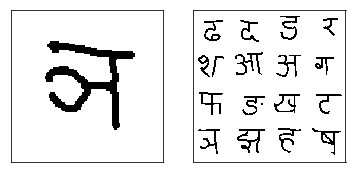

In [ ]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

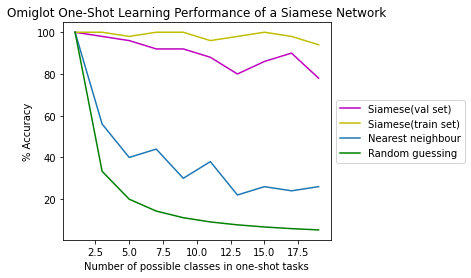

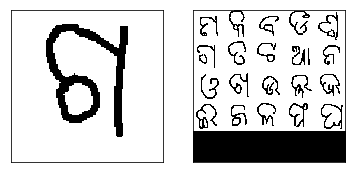

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)

References Used :

https://github.com/shashankhalo7/Omniglot_meta_learning/blob/master/osl.ipynb

http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf